In [38]:
import json
import os
import random
import re  # Expresiones regulares
import sys  # Interactuar con el sistema
from itertools import chain, combinations  # Iteradores
from pathlib import Path

import geopandas as gpd  # Georeferenciacion
import matplotlib.pyplot as plt  # Visualización de datos
import numpy as np  # Albegra lineal
import osmnx as ox  # OpenStreetMap
import pandas as pd  # Procesamiento de datos
import scipy.stats as stats
import seaborn as sns  # Visualización de datos estadísticos
import sklearn
import utils
from geopandas.datasets import get_path  # Ruta de los datos geográficos
from scipy.stats import chi2_contingency  # Test de chi-cuadrado
from shapely.geometry import Point  # Geometría espacial
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,  # Metricas para evaluación
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from ydata_profiling import ProfileReport

In [39]:
pd.options.mode.chained_assignment = None

random_seed = 42
random.seed(random_seed)

main_path = Path.cwd() / ".."
df = pd.read_csv(main_path / "data/weatherAUS.csv")

spectral_palette = [
    "#9e0142",
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
    "#5e4fa2",
]

---

#### Data cleansing

Eliminamos las observaciones sin ground truth en la variable objetivo, ya que no van a ser necesarias para el entrenamiento (debido a la gran cantidad de observaciones con las que contamos y la relativamente baja proporción de datos faltantes en la variable objetivo), y tampoco nos van a ser útiles para evaluar el modelo ya que en la immputación podemos introducir ciertos sesgos.

In [40]:
print(
    f"Proporción de datos faltantes en la variable objetivo: {round(df.RainTomorrow.isna().mean(), 3)}"
)

Proporción de datos faltantes en la variable objetivo: 0.022


In [41]:
df = df.dropna(subset=["RainTomorrow"])

---

#### Categorical features encoding

##### Rain Today and Rain Tomorrow

In [42]:
rain_columns = ["RainToday", "RainTomorrow"]
mapping_dict = {"Yes" : 1, "No" : 0}

for column in rain_columns:
    df[column] = df[column].map(mapping_dict)

##### Location

In [43]:
# Geolocate stations
country = "Australia"

mapping_dict = {"Dartmoor": "DartmoorVillage", "Richmond": "RichmondSydney"}
df["Location"] = df["Location"].map(mapping_dict).fillna(df["Location"])

locations = df["Location"].unique()
locations = [re.sub(r"([a-z])([A-Z])", r"\1 \2", l) for l in locations]

locs = []
lats = []
lons = []
for location in locations:
    try:
        lat, lon = ox.geocode(location + f", {country}")

        locs.append(location.replace(" ", ""))
        lats.append(lat)
        lons.append(lon)
    except Exception as e:
        print(f"Error retrieving coordinates for {location}: {e}")

df_locations = pd.DataFrame({"Location": locs, "Lat": lats, "Lon": lons})

df = pd.merge(df, df_locations, how="left", on="Location")

##### Date

In [44]:
df["Date"] = pd.to_datetime(df["Date"])

df['DayOfYear'] = df['Date'].dt.dayofyear
df['DaysInYear'] = df['Date'].dt.is_leap_year.apply(lambda leap: 366 if leap else 365)

df['Angle'] = 2 * np.pi * (df['DayOfYear'] - 1) / (df['DaysInYear'])

df['DayCos'] = np.cos(df['Angle'])
df['DaySin'] = np.sin(df['Angle'])

df = df.drop(columns=["DayOfYear", "DaysInYear", "Angle"])

##### Wind Dir

In [45]:
dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]
angles = np.radians(np.arange(0, 360, 22.5))
mapping_dict = {d: a for (d, a) in zip(dirs, angles)}

wind_dir_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]
for column in wind_dir_columns:
    df[f"{column}Angle"] = df[column].map(mapping_dict)

    df[f"{column}Cos"] = np.cos(df[f"{column}Angle"])
    df[f"{column}Sin"] = np.sin(df[f"{column}Angle"])

    df = df.drop(columns=f"{column}Angle")

---

#### Train Test split

Vamos a utilizar una proporción de 0.7|0.15|0.15 para train, validation and test sets respectivamente. Este split no vamos a realizarlo seleccionadas observaciones completamente al azar, sino que por el contrario vamos a considerar todas las observaciones correspondientes a una serie de fechas seleccionadas al azar. Esto nos permitirá evitar el fenómeno de data leaking dado por un modelo que aprenda que en un determinado día y en un determinado sector geográfico hay lluvia al día siguiente (positivo para la clase objetivo) a partir de observaciones para el mismo día en estaciones cercanas entre si. Recordemos que, cómo vimos en el análisis exploratorio de datos, encontramos estaciones meteorológicas muy cercanas entre si con correlaciones cercanas a 0.8 para la probabilidad de lluvia en un mismo día.

In [46]:
def split_list(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of the split ratios must be 1.0")
    
    random.shuffle(data)

    total_size = len(data)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    
    train_set = data[:train_size]
    val_set = data[train_size:(train_size + val_size)]
    test_set = data[(train_size + val_size):]
    
    return train_set, val_set, test_set

In [47]:
list_dates = df["Date"].unique().tolist()
train_dates, val_dates, test_dates = split_list(list_dates)

train_filt = df["Date"].isin(train_dates + val_dates)
train_set = df.loc[train_filt, :].reset_index(drop=True)

test_filt = df["Date"].isin(test_dates)
test_set = df.loc[test_filt, :].reset_index(drop=True)

---

#### Numeric data transformation

In [48]:
numeric_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm"
]

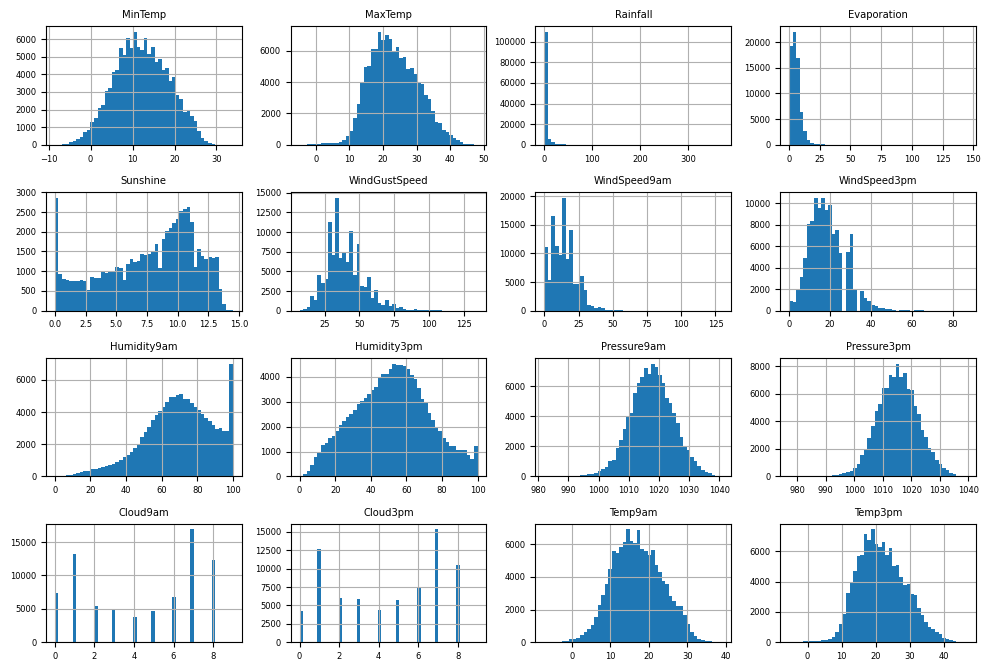

In [49]:
plt.rcParams.update({'font.size': 6})
train_set[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

In [50]:
train_set[numeric_columns].kurtosis(numeric_only=True)

MinTemp           -0.489722
MaxTemp           -0.237807
Rainfall         185.446037
Evaporation       47.464434
Sunshine          -0.825532
WindGustSpeed      1.409267
WindSpeed9am       1.206857
WindSpeed3pm       0.770985
Humidity9am       -0.045800
Humidity3pm       -0.516242
Pressure9am        0.226843
Pressure3pm        0.107626
Cloud9am          -1.542493
Cloud3pm          -1.458780
Temp9am           -0.349470
Temp3pm           -0.145123
dtype: float64

_Cabe remarcar, que la oblicuidad de la variable Rainfall se debe principalmente al desbalanceo del dataset (mayor cantidad de observaciones con clase negativa para las variables RainToday y RainTomorrow) y la relación determinística entre esta variable cuando asume valor 0 y un valor negativo para la variable RainToday._

Vamos a utilizar la función logarítmica en las variables "Rainfall" y "Evaporation" cuya métrica de oblicuidad es mayor a 2.

In [51]:
right_skewed_columns = ["Rainfall", "Evaporation"]
for column in right_skewed_columns:
    train_set[column] = np.log(train_set[column]+1)

---

#### Missing values imputation

In [52]:
index_columns = ["Date", "Location"]

feature_columns = [
    "Lat",
    "Lon",
    "DayCos",
    "DaySin",
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "WindGustDirCos",
    "WindGustDirSin",
    "WindDir9amCos",
    "WindDir9amSin",
    "WindDir3pmCos",
    "WindDir3pmSin",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
    "RainToday",
]

target_column = ["RainTomorrow"]

In [59]:
na_features_count = (
    pd.DataFrame(
        train_set[index_columns + feature_columns]
        .set_index(index_columns)
        .isna()
        .sum(axis=1)
    )
    .rename(columns={0: "count"})
    .sort_values(by="count", ascending=False)
)

In [67]:
filt = na_features_count["count"] > len(feature_columns) / 2
na_features_count.loc[filt, :].reset_index()["Location"].value_counts()

Location
Newcastle          458
CoffsHarbour       209
Canberra           167
MountGinini        147
Albany              32
SalmonGums          25
PearceRAAF           9
Cobar                6
BadgerysCreek        5
RichmondSydney       5
Penrith              4
NorahHead            2
Adelaide             2
Walpole              2
Tuggeranong          1
Witchcliffe          1
DartmoorVillage      1
Moree                1
Sale                 1
Ballarat             1
Williamtown          1
Nuriootpa            1
Name: count, dtype: int64

In [72]:
geometry = [Point(lon, lat) for lon, lat in zip(df_locations['Lon'], df_locations['Lat'])]
gdf_locations = gpd.GeoDataFrame(df_locations, geometry=geometry, crs="EPSG:4326")

locations = gdf_locations["Location"].unique()
location_pairs = list(combinations(locations, 2))

df_location_pairs = pd.DataFrame(location_pairs, columns=['LocationA', 'LocationB'])

df_location_a = df_location_pairs[["LocationA"]].merge(
    gdf_locations[["Location", "geometry"]],
    how="left",
    left_on="LocationA",
    right_on="Location",
)
gdf_location_a = gpd.GeoDataFrame(df_location_a, geometry="geometry")
gdf_location_a_gda94 = gdf_location_a.to_crs(epsg=3112)

df_location_b = df_location_pairs[["LocationB"]].merge(
    gdf_locations[["Location", "geometry"]],
    how="left",
    left_on="LocationB",
    right_on="Location",
)
gdf_location_b = gpd.GeoDataFrame(df_location_b, geometry="geometry")
gdf_location_b_gda94 = gdf_location_b.to_crs(epsg=3112)

distance_ab = gdf_location_a_gda94["geometry"].distance(gdf_location_b_gda94["geometry"])

df_location_pairs["distance"] = distance_ab / 1000 # distance in kilometers

In [79]:
locations = df["Location"].unique()
location_pairs = list(combinations(locations, 2))

df_location_pairs = pd.DataFrame(location_pairs, columns=['LocationA', 'LocationB'])
df_location_pairs['phi'] = np.nan
df_location_pairs['pvalue'] = np.nan

for index, row in df_location_pairs.iterrows():
    loc1, loc2 = row['LocationA'], row['LocationB']
    df_pair = df[df['Location'].isin([loc1, loc2])]
    df_pivot = df_pair.pivot(index='Date', columns='Location', values='RainToday').dropna()
    
    if not df_pivot.empty:
        confusion_matrix = pd.crosstab(df_pivot[loc1], df_pivot[loc2])
        phi, pvalue = utils.phi_coefficient(confusion_matrix.values)
        df_location_pairs.at[index, 'phi'] = phi
        df_location_pairs.at[index, 'pvalue'] = pvalue

In [80]:
df_location_a = df_location_pairs[["LocationA"]].merge(
    gdf_locations[["Location", "geometry"]],
    how="left",
    left_on="LocationA",
    right_on="Location",
)
gdf_location_a = gpd.GeoDataFrame(df_location_a, geometry="geometry")
gdf_location_a_gda94 = gdf_location_a.to_crs(epsg=3112)

df_location_b = df_location_pairs[["LocationB"]].merge(
    gdf_locations[["Location", "geometry"]],
    how="left",
    left_on="LocationB",
    right_on="Location",
)
gdf_location_b = gpd.GeoDataFrame(df_location_b, geometry="geometry")
gdf_location_b_gda94 = gdf_location_b.to_crs(epsg=3112)

distance_ab = gdf_location_a_gda94["geometry"].distance(gdf_location_b_gda94["geometry"])

df_location_pairs["distance"] = distance_ab / 1000 # distance in kilometers

In [81]:
filt = df_location_a

,LocationA,LocationB,phi,pvalue,distance
1131,PerthAirport,Perth,0.868273,0.000000e+00,10.170125
435,Sydney,SydneyAirport,0.834408,0.000000e+00,9.159054
615,Canberra,Tuggeranong,0.832272,0.000000e+00,13.690617
1121,PearceRAAF,PerthAirport,0.808868,0.000000e+00,29.675737
356,Penrith,RichmondSydney,0.795472,0.000000e+00,17.339476
950,DartmoorVillage,MountGambier,0.776626,0.000000e+00,45.125869
1122,PearceRAAF,Perth,0.775134,0.000000e+00,34.306090
54,BadgerysCreek,Penrith,0.775131,0.000000e+00,15.112316
828,Melbourne,Watsonia,0.757644,2.988961e-264,15.719700
55,BadgerysCreek,RichmondSydney,0.744563,0.000000e+00,30.966137


In [86]:
loc  = "Albany"

filt = (df_location_pairs["LocationA"]==loc) | (df_location_pairs["LocationB"]==loc)
df_location_pairs.loc[filt, :].sort_values(by="distance").head()

,LocationA,LocationB,phi,pvalue,distance
1103,Albany,Walpole,0.623179,3.213975e-232,105.066740
1098,Albany,Witchcliffe,0.529060,2.512429e-177,277.430379
1100,Albany,PerthAirport,0.461122,3.974266e-139,383.345263
1101,Albany,Perth,0.470361,3.613736e-146,386.529836
1099,Albany,PearceRAAF,0.428011,5.441950e-106,407.681517


Yo las puedo borrar de acá a esas observaciones. Lo importante es pensar que voy a hacer con ellas llegado el momento de testear. Sería interesante tener una suerte de pipeline para resolver al menos las más graves utilizando las estaciones meteorológicas más cercanas.